## import stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid')

import os
import collections
import glob

import scipy.optimize
import scipy.stats

## get data

In [2]:
mut_list = pd.read_csv('mut-list.csv',  sep=',', dtype={'geno' : str}, index_col=[0])
mut_list

,shortname
a,som14


In [3]:
run_list = pd.read_csv('run-list.csv')
run_list

,directory,row,shortname,mutant,antigen,replicate,prefix
0,../../Raw_facs_data/20210205_p2,E,som14,a,H1,1,NaN
1,../../Raw_facs_data/20210205_p2,G,som14,a,H9,1,NaN
2,../../Raw_facs_data/20210212_p2,E,som14,a,H1,2,NaN
3,../../Raw_facs_data/20210212_p2,G,som14,a,H9,2,NaN


In [4]:
concentrations_list = pd.read_csv('concentrations-list.csv', index_col=[0])
cols = concentrations_list.index
concentrations_list

,H1,H9,H1_angela,H9_angela
well column,,,,
1,7.017969,7.002664,7.04646,7.019901
2,7.517969,7.502664,7.54646,7.519901
3,8.017969,8.002664,8.04646,8.019901
4,8.517969,8.502664,8.54646,8.519901
5,9.017969,9.002664,9.04646,9.019901
6,9.517969,9.502664,9.54646,9.519901
7,10.017969,10.002664,10.04646,10.019901
8,10.517969,10.502664,10.54646,10.519901
9,11.017969,11.002664,11.04646,11.019901


In [5]:
def get_run_jeff(run_id):
    run_row = run_list.loc[run_id,:]
    wells = ['%c%02d' % (run_row['row'], i) for i in range(1,13)]
    def get_filename(well):
        search =  os.path.join(run_row['directory'], '*%s*' % well)
        filenames = glob.glob(search)
        if len(filenames) != 1:
            print(search, filenames)
            raise Exception(well)
        return filenames[0]

    read = pd.read_csv
        
    return [read(get_filename(well)) for well in wells]

def get_run(run_id):
    if pd.isna(run_list['prefix'])[run_id]:
        run = get_run_jeff(run_id)
    else:
        run = get_run_angela(run_id)
    #use compensated values
    if 'Comp-PE-A' in run[0]:
        for df in run:
            df['PE-A'] = df['Comp-PE-A']
            df['FITC-A'] = df['Comp-FITC-A']
    #transform by minimum PE value and take log
    PE_min = min(df['PE-A'].min() for df in run)
    for df in run:
        df['log_PE'] = np.log10(df['PE-A'] - PE_min + 1)
        df['log_FITC'] = np.log10(df['FITC-A'])
        
    run_row = run_list.loc[run_id,:]
    print(run_row['shortname'], run_row['antigen'], PE_min, sep='\t')
    
    return run
    
print('name', 'antigen', 'min PE fluor', sep='\t')
runs = [get_run(run_id) for run_id in run_list.index]

name	antigen	min PE fluor
som14	H1	-197.34
som14	H9	-1415.7
som14	H1	-127.92
som14	H9	-219.96


## fit mean log fluor to [HA] to calculate Kd

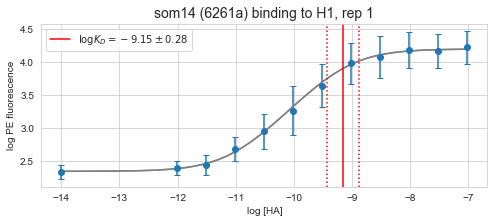

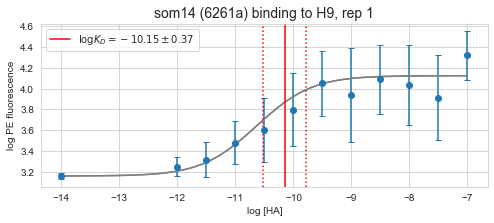

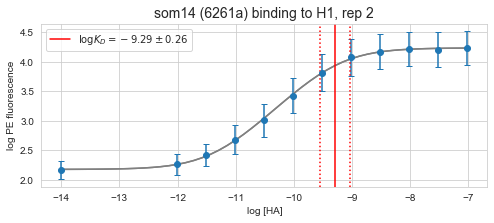

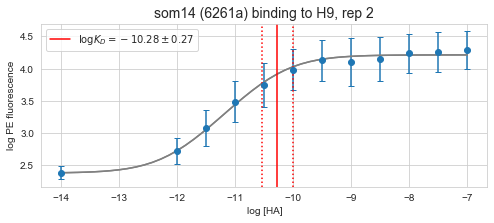

In [7]:
def sigmoid(c, Kd, A, B):
    return np.log10(A * (10**c/((10**c)+(10**Kd))) + B)

def rms(y, yfit):
    return np.sqrt(np.sum((y-yfit)**2))

n_runs = run_list.shape[0]
run_list['KD'] = np.zeros(n_runs)
run_list['KD_err'] = np.zeros(n_runs)

for i,run in enumerate(runs):
    mean_log_fluor = [df['log_PE'].mean() for df in run]
    std_log_fluor = [df['log_PE'].std() for df in run]
    
    antigen = run_list['antigen'][i]
    concs = (-concentrations_list[antigen]).copy()

    
    popt, pcov = scipy.optimize.curve_fit(sigmoid,
                                          concs,
                                          mean_log_fluor,
                                          p0=[(-9),10**(4),10**(1)],
                                          sigma=std_log_fluor,
                                          absolute_sigma=True,
                                          bounds = [((-14),1,1),((-5),10**(5),10**(5))],
                                          maxfev=400000)
    
    logKd = popt[0]
    logKd_err = np.sqrt(pcov[0][0])
    run_list.loc[i,'KD'] = logKd
    run_list.loc[i,'KD_err'] = logKd_err
    
    concs_plot = np.linspace(concs.min(), concs.max())
    
    plt.figure(figsize=(8,3))
    plt.errorbar(concs, mean_log_fluor, yerr=std_log_fluor, fmt='o', capsize=3)
    plt.plot(concs_plot, sigmoid(concs_plot, *popt), color='grey')
    plt.plot(concs_plot, sigmoid(concs_plot, *popt), color='grey')
    plt.axvline(logKd, linestyle='-', color='red',
               label=r'$\log K_D = %.2f \pm %.2f$' % (logKd, logKd_err))
    plt.axvline(logKd + logKd_err, linestyle=':', color='red')
    plt.axvline(logKd - logKd_err, linestyle=':', color='red')
    plt.xlabel('log [HA]')
    plt.ylabel('log PE fluorescence')
    plt.title('%s (6261%s) binding to %s, rep %s' %
              (run_list.loc[i,'shortname'], 
               run_list.loc[i,'mutant'],
               run_list.loc[i,'antigen'],
               run_list.loc[i,'replicate']),
              fontsize=14)
    plt.legend()
    plt.show()

## merge with titeseq data 

In [9]:
antigen_map = {'H1':'h1', 'H9':'h9'}
run_list['run_id'] = run_list.index
for row in run_list.index:
    antigen = run_list['antigen'][row]
    mutant = run_list['mutant'][row]
    if run_list['shortname'][row].endswith('syn'):
        continue
    if mutant == 'germline':
        mutant = 'm'
    if mutant == 'somatic':
        mutant = 'n'

In [11]:
results = run_list.set_index(['antigen', 'shortname', 'replicate']).sort_index()[['run_id', 'KD', 'KD_err']]
results.loc[results.KD > -7, 'KD'] = -7
results = results[results['KD_err'] < 1]
results.to_csv('fitted_Kds.csv')
results

run_id         KD    KD_err
antigen shortname replicate                             
H1      som14     1               0  -9.153649  0.277946
                  2               2  -9.290719  0.264906
H9      som14     1               1 -10.153371  0.371282
                  2               3 -10.275734  0.270712

In [13]:
g = results.groupby(['antigen', 'shortname'])
results_merge = pd.DataFrame({
    'KD' : -g.mean()['KD'],
    'KD_err' : g.std()['KD']})
results_merge

,,KD,KD_err
antigen,shortname,,
H1,som14,9.222184,0.096923
H9,som14,10.214553,0.086524


## comparison to isogenic measurements

In [2]:
som_14_h1 = np.array([-9.153649, -9.290719])
som_14_h1_mean = som_14_h1.mean()
som_14_h1_sem = som_14_h1.std()
som_14_h9 = np.array([-10.153371, -10.275734])
som_14_h9_mean = som_14_h9.mean()
som_14_h9_sem = som_14_h9.std()
som_h1 = np.array([-9.504139081844661, -9.503407397619684])
som_h1_mean = som_h1.mean()
som_h1_sem = som_h1.std()
som_h9 = np.array([-10.190717035679013, -10.160267401601297])
som_h9_mean = som_h9.mean()
som_h9_sem = som_h9.std()

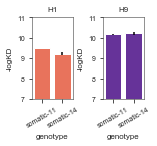

In [20]:
sns.set_style('ticks')
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
h1_x= ['somatic-11','somatic-14']
h1_y = [-som_h1_mean,-som_14_h1_mean]
h1_y_err = [-som_h1_sem,-som_14_h1_sem]
h3_x= ['somatic-11','somatic-14']
h3_y = [-som_h9_mean,-som_14_h9_mean]
h3_y_err = [-som_h9_sem,-som_14_h9_sem]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(2,1.5))
ax2.bar(h3_x,h3_y, yerr=h3_y_err,color='rebeccapurple')
ax2.set_ylim(7,11)
ax2.set_ylabel('-logKD',fontsize=8)
ax2.set_xlabel('genotype',fontsize=8)
ax2.tick_params(axis='x',rotation=30,labelsize=7)
ax2.set_title('H9',fontsize=8)
ax2.tick_params(axis='y',labelsize=7)
ax1.bar(h1_x,h1_y, yerr=h1_y_err, color='#e8735c')
ax1.set_ylim(7,11)
ax1.set_ylabel('-logKD',fontsize=8)
ax1.set_xlabel('genotype',fontsize=8)
ax1.set_title('H1',fontsize=8)
ax1.tick_params(axis='x',rotation=30,labelsize=7)
ax1.tick_params(axis='y',labelsize=7)
plt.subplots_adjust(wspace=0.75)
plt.savefig('6261_revertant_comparison.png',dpi=1200,bbox_inches='tight')